In [1]:
# Bibliotecas Utilizadas no Pre Processamento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mmh3
import random
%matplotlib inline

In [2]:
%%capture
from tqdm import notebook as nb_tqdm
nb_tqdm.tqdm().pandas()

## Importando dados a serem utilizados

In [3]:
# Colunas úteis de cada uma das tabelas utilizadas
messages_cols = ['AC','FLIGHT','TIME','FLIGHT_PHASE','TYPE','MESSAGE']
sensors_cols = ['AC','FLIGHT','TIME','AMBIENT_1','PAR_AC_1','PAR_AC_2',
                'PAR_SYS_1','PAR_SYS_2','PAR_SYS_3','PAR_SYS_5','PAR_SYS_7',
                'PAR_SYS_8','PAR_SYS_9','PAR_SYS_10']

# Escolhendo 3 sensores não essenciais da colunas sensors
random_sensors_ind = []
while len(random_sensors_ind) != 3:
    r = random.randint(3,13)
    if r not in random_sensors_ind: random_sensors_ind.append(r)

# Colunas a serem utilizadas em cada uma das tabelas
sensors_used_cols = [sensors_cols[0],sensors_cols[1],sensors_cols[2],sensors_cols[random_sensors_ind[0]],
                     sensors_cols[random_sensors_ind[1]],sensors_cols[random_sensors_ind[2]]]
messages_used_cols = messages_cols

# Imprimindo features utilizadas
print("Colunas utilizadas da tabela Sensors: ", sensors_used_cols)
print('')
print("Colunas utilizadas da tabela Messages: ", messages_used_cols)

Colunas utilizadas da tabela Sensors:  ['AC', 'FLIGHT', 'TIME', 'PAR_SYS_7', 'PAR_SYS_1', 'PAR_SYS_9']

Colunas utilizadas da tabela Messages:  ['AC', 'FLIGHT', 'TIME', 'FLIGHT_PHASE', 'TYPE', 'MESSAGE']


In [4]:
# Importanto dados utilizados
messages = pd.read_csv('databases/private-data/messages.csv',usecols=messages_cols)
sensors = pd.read_csv('databases/private-data/sensors.csv',usecols=sensors_cols)

# Fetching public data
public = pd.read_csv('databases/public.csv')

In [5]:
# Importando tabela auxiliar da análise da ordem dos voos
flight_orders = pd.read_csv('flight_order_analysis.csv')

### Restringindo as tabelas Mensagens e Sensores para o Voos com Label

In [6]:
# Escolhendo voos
public_reduced = public.copy() # Trocar por public.head(NUM_VOOS).copy() se for testar com menos voos

# Armazenando os voos que serão previstos
flights = set(public_reduced['FLIGHT'].unique())

In [7]:
# Reduzindo a tabela flight orders para somente os voos estudados
flight_orders_reduced = flight_orders[flight_orders['FLIGHT'].isin(flights)].copy()

In [8]:
# Reduzindo sensors e messages para somente os voos estudados
sensors_reduced = sensors[sensors['FLIGHT'].isin(flights)].copy()
messages_reduced = messages[messages['FLIGHT'].isin(flights)].copy()

# Tirando as duplicatas
sensors_reduced.drop_duplicates(inplace=True)
messages_reduced.drop_duplicates(inplace=True)

In [9]:
# Função para limitar o número de linhas por voo
def limitNumberOfRowsPerFlight(df,flight_col_name,limit_rows):
    # Criando um data frame auxiliar com as mesmas colunas do original
    reduced_df = pd.DataFrame(columns = list(df.columns))
    
    # Setando limite de linhas por VOO
    LIMIT_ROWS_PER_FLIGHT = limit_rows
    
    # Unique Flights in DF
    unique_flights = list(df[flight_col_name].unique())
    
    # Montando a tabela iterando em cada um dos voos únicos
    for uf in nb_tqdm.tqdm(unique_flights): 
        # Armazenando em quais indices do DF original estão os registros desse voo                
        indices = list(df[df[flight_col_name] == uf].index)            

        # Verificando se o número de Voos é maior que o limite. Se for, faz-se a redução
        if len(indices) > LIMIT_ROWS_PER_FLIGHT:
            # Escolhendo indices aleatórios
            random.seed(4)
            limited_indices = random.sample(indices,LIMIT_ROWS_PER_FLIGHT)
        else:
            limited_indices = indices
            
        limited_indices.sort() # Garantindo ordem crescente dos índices

        # Preenchendo o novo DataFrame
        reduced_df = reduced_df.append(df[df.index.isin(limited_indices)],ignore_index=True)
            
    return reduced_df

In [10]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_reduced = limitNumberOfRowsPerFlight(sensors_reduced,'FLIGHT',200)
messages_reduced = limitNumberOfRowsPerFlight(messages_reduced,'FLIGHT',200)

## Unificando os dados em uma tabela

In [11]:
# Unindo flight_orders_reduced com sensors_reduced
sensors_reduced.set_index('FLIGHT',inplace=True)
flight_orders_reduced.set_index('FLIGHT',inplace=True)

sns_and_flights = sensors_reduced.merge(flight_orders_reduced,left_on="FLIGHT",right_on="FLIGHT",how="inner",suffixes=('_sns','_flg')).progress_apply(lambda x:x)

# Unindo com a tabela messages
messages_reduced.set_index('FLIGHT',inplace=True)

sns_and_msg = sns_and_flights.merge(messages_reduced,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x:x)
sns_and_msg.drop('AC_msg',axis=1,inplace=True)

# Unindo com a tabela public
public_reduced.set_index('FLIGHT',inplace=True)

model_data = sns_and_msg.merge(public_reduced,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sm','_pb')).progress_apply(lambda x:x)

In [12]:
# Voltando para índice original
model_data.reset_index(inplace=True)

In [13]:
model_data

,FLIGHT,AC_sns,TIME_sns,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_SYS_1,PAR_SYS_2,PAR_SYS_3,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,PAR_SYS_7,PAR_SYS_8,ORDER,TIME_msg,FLIGHT_PHASE,TYPE,MESSAGE,MAINTENANCE
0,006042,AC19,3115,11723.0,0.00000,29.11250,65.375,247.0,73.250,0.0,0.0,0.0,0.000,16.2000,20,NaN,NaN,NaN,NaN,4
1,006042,AC19,3132,11721.0,0.00000,29.28375,65.375,299.0,68.125,0.0,0.0,0.0,0.000,0.0000,20,NaN,NaN,NaN,NaN,4
2,006042,AC19,3204,11721.0,29.28375,29.45500,44.250,279.0,43.750,0.0,0.0,1.0,99.225,111.0375,20,NaN,NaN,NaN,NaN,4
3,006042,AC19,3218,11721.5,29.45500,29.62625,43.875,230.0,43.500,0.0,0.0,1.0,112.725,121.1625,20,NaN,NaN,NaN,NaN,4
4,006042,AC19,3266,11721.0,29.28375,29.62625,42.875,265.0,43.375,0.0,0.0,1.0,129.600,123.1875,20,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638395,fe38f6,AC36,5689,12230.0,30.65375,13.87125,44.375,245.0,22.750,0.0,0.0,1.0,98.550,44.5500,36,NaN,NaN,NaN,NaN,10
638396,fe38f6,AC36,5699,12230.5,0.00000,0.00000,22.250,234.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10
638397,fe38f6,AC36,5719,12231.5,10.44625,0.00000,22.375,235.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10
638398,fe38f6,AC36,5736,12234.0,0.00000,0.00000,22.250,234.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10


## Data Imputing

In [14]:
# Checando número de entradas nulas por coluna
model_data.isnull().sum()

FLIGHT               0
AC_sns               0
TIME_sns             0
AMBIENT_1            0
PAR_AC_1             0
PAR_AC_2             0
PAR_SYS_1            0
PAR_SYS_2            0
PAR_SYS_3            0
PAR_SYS_9            0
PAR_SYS_10           0
PAR_SYS_5            0
PAR_SYS_7            0
PAR_SYS_8            0
ORDER                0
TIME_msg        102000
FLIGHT_PHASE    102000
TYPE            102000
MESSAGE         102000
MAINTENANCE          0
dtype: int64

In [15]:
# Data Imputing
model_data['TIME_msg'].fillna(0,inplace=True) # Preenchendo com valor O para o caso dos sensores em que não há mensagem
model_data['FLIGHT_PHASE'].fillna(0,inplace=True) # Preenchendo com valor 0 para o caso dos sensores em que não há mensagem
model_data['TYPE'].fillna('SM',inplace=True) # SM =  Sem Mensagem
model_data['MESSAGE'].fillna(100,inplace=True) # Codigo correspondente ao caso da ausência de messagem

## Renomeando as colunas

In [16]:
# Colunas atuais
model_data.columns

Index(['FLIGHT', 'AC_sns', 'TIME_sns', 'AMBIENT_1', 'PAR_AC_1', 'PAR_AC_2',
       'PAR_SYS_1', 'PAR_SYS_2', 'PAR_SYS_3', 'PAR_SYS_9', 'PAR_SYS_10',
       'PAR_SYS_5', 'PAR_SYS_7', 'PAR_SYS_8', 'ORDER', 'TIME_msg',
       'FLIGHT_PHASE', 'TYPE', 'MESSAGE', 'MAINTENANCE'],
      dtype='object')

In [17]:
# Renomeando as colunas
model_data.columns = ['flight','ac','sensor_time','ambient_1','sensor_par_ac_1','sensor_par_ac_2',
                      'sensor_par_sys_1','sensor_par_sys_2','sensor_par_sys_3','sensor_par_sys_9',
                      'sensor_par_sys_10','sensor_par_sys_5','sensor_par_sys_7','sensor_par_sys_8',
                      'order','message_time','flight_phase','message_type','message','target']

In [18]:
# Corrigind tipo da coluna sensor_time
model_data['sensor_time'] = model_data['sensor_time'].astype(int)

## Feature Engineering

#### Estudando as correlações de cada uma das features com a variável target

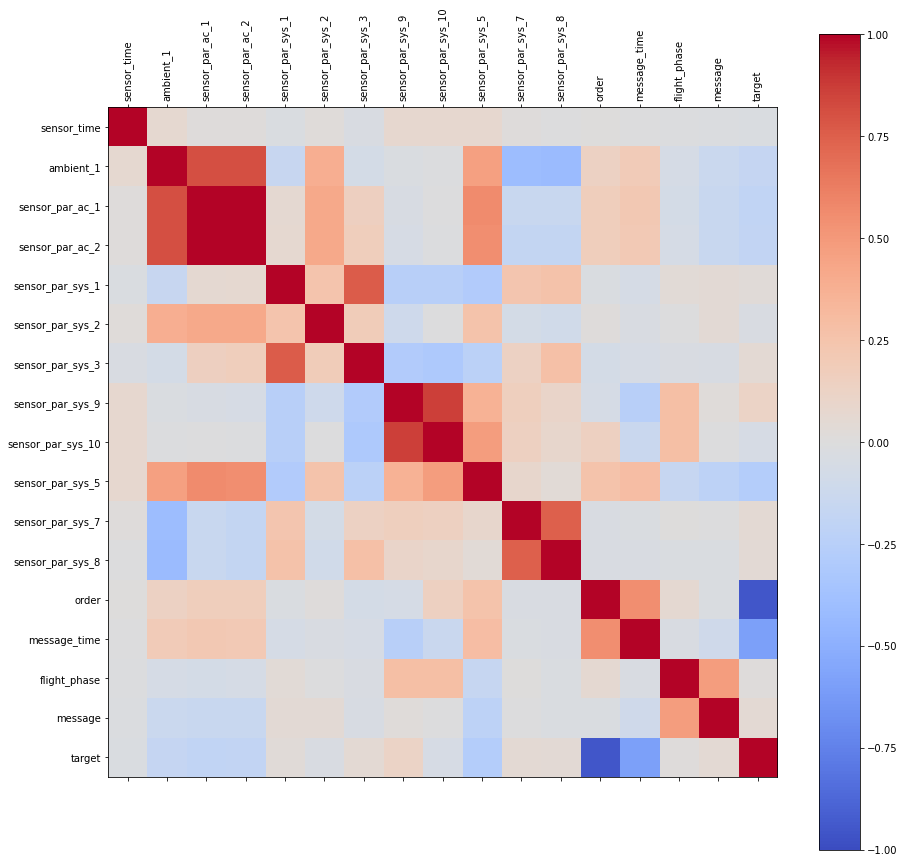

In [19]:
# Separando somente as colunas numéricas
num_cols = model_data._get_numeric_data().columns

# Slicing data - Somente variáveis numéricas
numerical_model_data = model_data[num_cols].copy()

# Visão geral das correlações existentes
corr = numerical_model_data.corr()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(numerical_model_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(numerical_model_data.columns)
ax.set_yticklabels(numerical_model_data.columns)
plt.show()

In [20]:
# Biblioteca utilizada
from scipy.stats import pearsonr

# Iterando entre as colunas numéricas
correlations = {}
for num_feature in num_cols:
    corr,_ = pearsonr(model_data[num_feature],model_data['target']) # Usando correlação de Pearson
    correlations[num_feature] = corr
    
# Imprimindo o resultado
for elem in correlations:
    print('A correlação entre o elemento {} e a variável target foi de: {}'.format(elem,correlations[elem]))

A correlação entre o elemento sensor_time e a variável target foi de: -0.025344615352336675
A correlação entre o elemento ambient_1 e a variável target foi de: -0.16742070205126566
A correlação entre o elemento sensor_par_ac_1 e a variável target foi de: -0.18829166823095753
A correlação entre o elemento sensor_par_ac_2 e a variável target foi de: -0.18749626247085677
A correlação entre o elemento sensor_par_sys_1 e a variável target foi de: 0.029448582879787685
A correlação entre o elemento sensor_par_sys_2 e a variável target foi de: -0.03404121732520424
A correlação entre o elemento sensor_par_sys_3 e a variável target foi de: 0.05385666527426065
A correlação entre o elemento sensor_par_sys_9 e a variável target foi de: 0.12241818898464582
A correlação entre o elemento sensor_par_sys_10 e a variável target foi de: -0.05110241637427282
A correlação entre o elemento sensor_par_sys_5 e a variável target foi de: -0.2697703057663402
A correlação entre o elemento sensor_par_sys_7 e a vari

### Variáveis mais relevantes para o modelo

In [21]:
relevant_features = ['order','message_time','sensor_par_sys_5','sensor_par_sys_9',
                     'sensor_par_ac_1','sensor_par_ac_2','ambient_1']

### Encoding de Variáveis Categóricas

In [22]:
# Filtrando somente os colunas categóricas
cat_cols = set(model_data.columns) - set(num_cols) # Armazenando colunas categóricas

In [23]:
# Printando as variáveis categóricas
cat_cols

{'ac', 'flight', 'message_type'}

In [24]:
# Hash Function
def hash_function(df,cat_name):
    return df[cat_name].progress_apply(lambda x: mmh3.hash(x,seed=42,signed=False))

In [25]:
# Aplicando o encoding
model_data['ac'] = hash_function(model_data,cat_name='ac')
model_data['flight'] = hash_function(model_data,cat_name='flight')
model_data['message_type'] = hash_function(model_data,cat_name='message_type')

### Finalmente após todo o processo de Feature Engineering

In [26]:
# Armazenando as variáveis numéricas escolhidas
data = model_data[relevant_features].copy()
data['ac'] = model_data['ac'].copy()
data['flight'] = model_data['flight'].copy()
data['message_type'] = model_data['message_type'].copy()
data['target'] = model_data['target'].copy()

# Por fim, vendo como fico ficou a data após feature engineering
data

,order,message_time,sensor_par_sys_5,sensor_par_sys_9,sensor_par_ac_1,sensor_par_ac_2,ambient_1,ac,flight,message_type,target
0,20,0,0.0,0.0,0.00000,29.11250,11723.0,3272462994,3945526026,101350308,4
1,20,0,0.0,0.0,0.00000,29.28375,11721.0,3272462994,3945526026,101350308,4
2,20,0,1.0,0.0,29.28375,29.45500,11721.0,3272462994,3945526026,101350308,4
3,20,0,1.0,0.0,29.45500,29.62625,11721.5,3272462994,3945526026,101350308,4
4,20,0,1.0,0.0,29.28375,29.62625,11721.0,3272462994,3945526026,101350308,4
...,...,...,...,...,...,...,...,...,...,...,...
638395,36,0,1.0,0.0,30.65375,13.87125,12230.0,1836135844,3552854091,101350308,10
638396,36,0,0.0,0.0,0.00000,0.00000,12230.5,1836135844,3552854091,101350308,10
638397,36,0,0.0,0.0,10.44625,0.00000,12231.5,1836135844,3552854091,101350308,10
638398,36,0,0.0,0.0,0.00000,0.00000,12234.0,1836135844,3552854091,101350308,10


## Splitting Data

In [27]:
# Bibliotecas para rodar o modelo e testar sua eficiência
from sklearn.model_selection import train_test_split

In [28]:
# Separando as features e a target
X,y = data.iloc[:,:-1],data.iloc[:,-1]

In [30]:
from sklearn.model_selection import train_test_split

# Separando Train e Validation sets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

## XGBoost Classifier

In [31]:
import xgboost as xgb

# Instanciando o modelo
xg_clf = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,verbosity=1,
                max_depth = 5, alpha = 10, n_estimators = 20)

# Treinando
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
# Testando o modelo
predictions_xg_clf = xg_clf.predict(X_valid)

In [33]:
# Acurária média
score_xg_clf = xg_clf.score(X_valid, y_valid)
print(score_xg_clf)

0.8735119047619048


In [36]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_xg_clf = np.sqrt(mean_squared_error(y_valid, predictions_xg_clf))
print("RMSE: %f" % (rmse_xg_clf))

RMSE: 1.238996


In [68]:
# KFold Validation
from sklearn.model_selection import cross_val_score

# Calculando os scores de acurácia para cada fold
accuracy_scores_xg_clf = cross_val_score(xg_clf,X,y,cv=5,scoring='accuracy')

# Mostrando resultados
print(accuracy_scores_xg_clf)

[0.47633145 0.5922854  0.64281798 0.67749843 0.61925125]


In [69]:
# Calculando RMSE para cada fold
rmse_scores_xg_clf = cross_val_score(xg_clf,X,y,cv=5,scoring='neg_root_mean_squared_error')

# Mostrando resultados
print(-rmse_scores_xg_clf)

[2.6380568  2.19438721 1.60971946 1.1756324  1.78374421]


## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Instanciando o modelo
rf_clf = RandomForestClassifier(n_estimators = 3,min_samples_leaf=10)

# Treinando
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
# Testando o modelo
predictions_rf_clf = rf_clf.predict(X_valid)

In [55]:
# Acurária média
score_rf_clf = rf_clf.score(X_valid, y_valid)
print(score_rf_clf)

0.9956375313283208


In [65]:
# KFold Validation
from sklearn.model_selection import cross_val_score

# Calculando os scores de acurácia para cada fold
accuracy_scores_rf_clf = cross_val_score(rf_clf,X,y,cv=5,scoring='accuracy')

# Mostrando resultados
print(accuracy_scores_rf_clf)

[0.54085213 0.62535244 0.66494361 0.66265664 0.63489192]


In [66]:
# Calculando RMSE para cada fold
rmse_scores_rf_clf = cross_val_score(rf_clf,X,y,cv=5,scoring='neg_root_mean_squared_error')

# Mostrando resultados
print(-rmse_scores_rf_clf)

[2.34529137 2.0530118  1.48808446 1.75418181 2.89376436]


In [58]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_rf_clf = np.sqrt(mean_squared_error(y_valid, predictions_rf_clf))
print("RMSE: %f" % (rmse_rf_clf))

RMSE: 0.233493


## ExtraTrees Classifier

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

# Instanciando o modelo
et_clf = ExtraTreesClassifier()

# Treinando
et_clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [60]:
# Testando o modelo
predictions_et_clf = et_clf.predict(X_valid)

In [61]:
# Acurária média
score_et_clf = et_clf.score(X_valid, y_valid)
print(score_et_clf)

0.9999295112781955


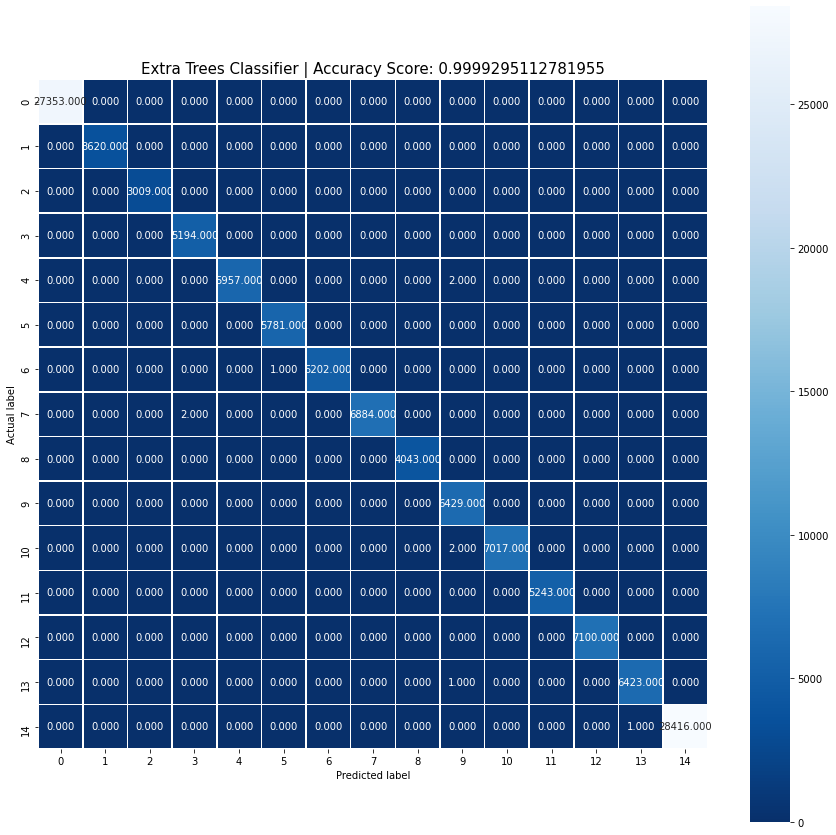

In [62]:
from sklearn import metrics

# Instanciando
cm_et_clf = metrics.confusion_matrix(y_valid, predictions_et_clf)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_et_clf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Extra Trees Classifier | Accuracy Score: {0}'.format(score_et_clf)
plt.title(all_sample_title, size = 15);

In [63]:
# Classification report
print(metrics.classification_report(y_valid, predictions_et_clf))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27353
           2       1.00      1.00      1.00      3620
           3       1.00      1.00      1.00      3009
           4       1.00      1.00      1.00      5194
           5       1.00      1.00      1.00      5959
           6       1.00      1.00      1.00      5781
           7       1.00      1.00      1.00      5203
           8       1.00      1.00      1.00      6886
           9       1.00      1.00      1.00      4043
          10       1.00      1.00      1.00      6429
          11       1.00      1.00      1.00      7019
          12       1.00      1.00      1.00      5243
          13       1.00      1.00      1.00      7100
          14       1.00      1.00      1.00      6424
          15       1.00      1.00      1.00     28417

    accuracy                           1.00    127680
   macro avg       1.00      1.00      1.00    127680
weighted avg       1.00   

In [64]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_et_clf = np.sqrt(mean_squared_error(y_valid, predictions_et_clf))
print("RMSE: %f" % (rmse_et_clf))

RMSE: 0.028264


#### Model Selection (K-fold Cross Validation e Grid Search)

In [51]:
# Importando bibliotecas auxiliares
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Instanciando modelo
clf = xgb.XGBClassifier(verbosity=3)

# Parâmetros 
grid_values = {'learning_rate':[0.05,0.10,0.15,0.20],
               'max_depth':[4,5,6,8]}

# Instaciando Grid Search
grid = GridSearchCV(clf,grid_values,cv=4,scoring='accuracy')

In [ ]:
# Treinando o modelo propriamente 
grid.fit(X,y)

In [45]:
# Separando Train e Validation sets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=41)

#### Otimização dos Hiperparâmetros

In [ ]:
# Importando método do Grid Search
from sklearn.model_selection import GridSearch

grid_values = {'learning_rate':[0.05,0.10,0.15,0.20],
               'max_depth':[3,4,5,6,8],
               'max_child_weight':[1,3,5,7]}

### Previsão dos dados sem Label

In [43]:
# Separando base de dados para teste (com label desconhecido)
public_flights = set(public['FLIGHT'].unique())
sensors_flights = set(sensors['FLIGHT'].unique())

test_flights = sensors_flights - public_flights

#### Preparando o vetor das features para esses dados

In [44]:
# Slicing
sensors_test = sensors[sensors['FLIGHT'].isin(test_flights)].copy()
messages_test = messages[messages['FLIGHT'].isin(test_flights)].copy()

In [45]:
# Tirando as duplicatas
sensors_test.drop_duplicates(inplace=True)
messages_test.drop_duplicates(inplace=True)

In [46]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_test = limitNumberOfRowsPerFlight(sensors_test,'FLIGHT',200)
messages_test = limitNumberOfRowsPerFlight(messages_test,'FLIGHT',200)

In [47]:
# Retirando colunas nulas
drop_columns = ['WAR_SYS_1','COM_SYS_1','WAR_SYS_2','WAR_SYS_3','PAR_AC_3','PAR_AC_4','PAR_SYS_5','PAR_SYS_6']
sensors_test.drop(drop_columns,axis=1,inplace=True)

# Escolhendo somente as colunas importantes
sensors_test = sensors_test[['AC','FLIGHT','TIME','AMBIENT_1','PAR_SYS_1','PAR_SYS_9']]

In [48]:
# Mudança de índices
sensors_test.set_index('FLIGHT',inplace=True)
messages_test.set_index('FLIGHT',inplace=True)

# Mergiando 
x_test = sensors_test.merge(messages_test,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x: x)
x_test.drop('AC_msg',axis=1,inplace=True)
x_test.reset_index(inplace=True)

In [49]:
# Preenchendo os valores nulos
x_test['TIME_msg'].fillna(0,inplace=True)  
x_test['FLIGHT_PHASE'].fillna(0,inplace=True) 
x_test['TYPE'].fillna('SM',inplace=True) 
x_test['MESSAGE'].fillna(100,inplace=True)

# Renomendo as colunas
x_test.columns = ['flight','ac','sensor_time','sensor_ambient',
                      'sensor_par_sys_1','sensor_par_sys_9',
                      'message_time','flight_phase','message_type',
                      'message']
    
x_test['sensor_time'] = x_test['sensor_time'].astype(int)

In [50]:
# Tratando as variáveis categóricas
num_cols = x_test._get_numeric_data().columns
cat_cols = set(x_test.columns) - set(num_cols)

# Salvando lista de voos, na ordem certa
test_flights_correct_order = x_test['flight']

# Aplicando Hash Function
x_test['ac'] = hash_function(x_test,cat_name='ac')
x_test['flight'] = hash_function(x_test,cat_name='flight')
x_test['message_type'] = hash_function(x_test,cat_name='message_type')

In [51]:
# Prevendo os dados de acorod com o modelo
y = xg_reg.predict(x_test)

In [81]:
# Formatando os dados para a saída prevista pelo Kaggle
data = x_test.copy()
data['target'] = list(y)
data['flight'] = test_flights_correct_order
output = data.groupby('flight')['target'].mean().progress_apply(lambda x:x)

# Ajustando o DF
df = output.reset_index()
df.index = np.arange(1,len(output)+1)
df.columns = ['FLIGHT','MAINTENANCE']

In [95]:
# Exportando a previsão para .CSV
df.to_csv('first_prediction.csv',index=False)

In [55]:
## Pre processamento na forma de Iteração
"""final_predictions = {}
i = 0
for f in nb_tqdm.tqdm(list(test_flights)):
    sns = sensors_test[sensors_test['FLIGHT'] == f]
    msg = messages_test[messages_test['FLIGHT'] == f]
    
    sns.set_index('FLIGHT',inplace=True)
    msg.set_index('FLIGHT',inplace=True)
    
    x_test = sns.merge(msg,left_on="FLIGHT", right_on="FLIGHT",how="left",suffixes=('_sns','_msg'))
    x_test.drop('AC_msg',axis=1,inplace=True)
    x_test.reset_index(inplace=True)
    
    x_test['TIME_msg'].fillna(0,inplace=True)  
    x_test['FLIGHT_PHASE'].fillna(0,inplace=True) 
    x_test['TYPE'].fillna('SM',inplace=True) 
    x_test['MESSAGE'].fillna(100,inplace=True)
    
    x_test.columns = ['flight','ac','sensor_time','sensor_ambient',
                      'sensor_par_sys_1','sensor_par_sys_9',
                      'message_time','flight_phase','message_type',
                      'message']
    
    x_test['sensor_time'] = x_test['sensor_time'].astype(int)
    
    num_cols = x_test._get_numeric_data().columns
    cat_cols = set(x_test.columns) - set(num_cols)
    
    x_test['ac'] = hash_function(x_test,cat_name='ac')
    x_test['flight'] = hash_function(x_test,cat_name='flight')
    x_test['message_type'] = hash_function(x_test,cat_name='message_type')
    
    final_predictions[f] = float(xg_reg.predict(x_test)[0])
    i += 1
    print('Number of predicted values: ',i)"""

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields sensor_time